In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

In this project, we are working with a large transactional dataset consisting of 6.3 million+ rows and 10 columns. The goal is to build a model that accurately identifies potentially fraudulent transactions.

In [3]:
df=pd.read_csv("Fraud.csv")

In [8]:
df.shape

(6362620, 11)

In [9]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Before jumping into cleaning or modeling, it’s crucial to understand the types of data we are dealing with. The .info() method shows us whether there are missing values, and .describe() helps us understand the distribution of numerical variables.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [12]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


We'll identify columns with missing data and handle them carefully in the cleaning phase. This is critical since missing values can significantly skew model performance.

In [13]:
missing=df.isnull().sum()
missing

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud detection datasets are often highly imbalanced. We'll confirm whether the number of fraudulent transactions is significantly less than non-fraudulent ones — this will impact how we train our model later.

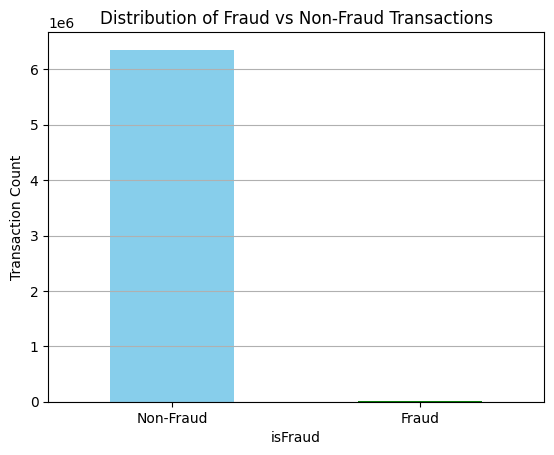

In [14]:
# Check distribution of fraud vs non-fraud transactions
df['isFraud'].value_counts().plot(kind='bar', color=['skyblue', 'green'])
plt.title("Distribution of Fraud vs Non-Fraud Transactions")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.ylabel("Transaction Count")
plt.grid(axis='y')
plt.show()

Before building any predictive model, it's important to understand the balance of classes in our target variable (isFraud). This is especially crucial in fraud detection since fraud is usually a rare event.

As seen above, the dataset is significantly imbalanced, with fraudulent transactions forming a small fraction of the total. This confirms the need for techniques such as oversampling, undersampling, or model-based class weighting later.`m

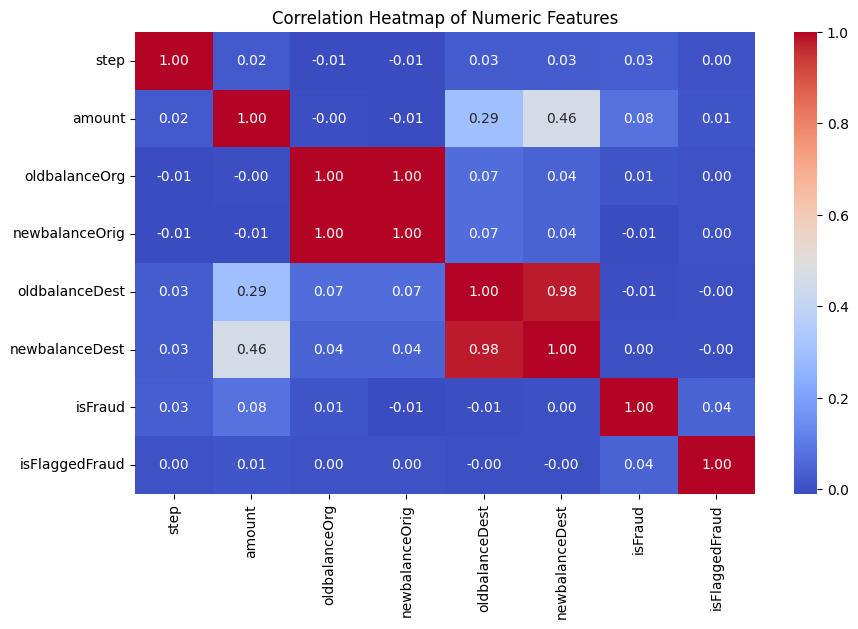

In [15]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


We use a correlation heatmap to detect linear relationships between numerical variables. Strong correlations could indicate multicollinearity — which we’ll explore further during feature selection. It’s also helpful to spot features that have noticeable correlation with isFraud.

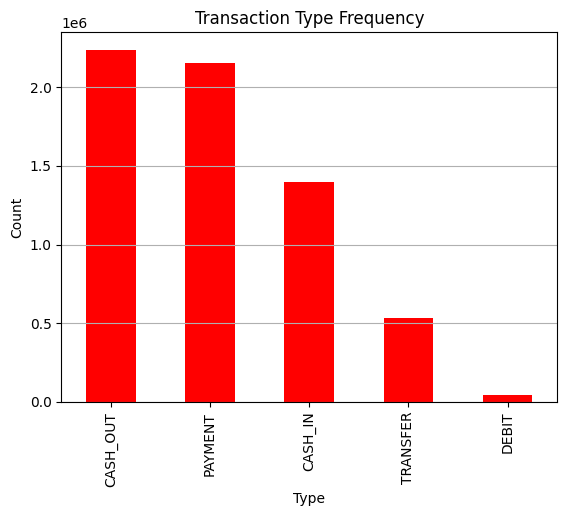

In [16]:
# Frequency of transaction types
df['type'].value_counts().plot(kind='bar', color='red')
plt.title("Transaction Type Frequency")
plt.xlabel("Type")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

Not all transaction types are equally frequent. We’ll later investigate which types are more likely to be fraudulent — for example, past studies show that TRANSFER and CASH_OUT are more fraud-prone.

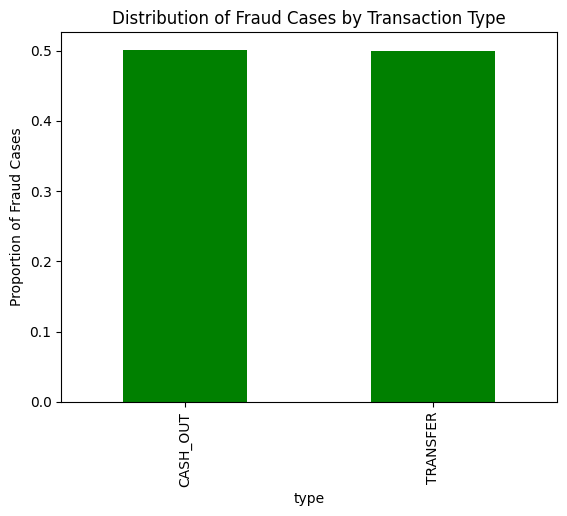

In [17]:
# Fraud rate by transaction type
fraud_type_rate = df[df['isFraud'] == 1]['type'].value_counts(normalize=True)
fraud_type_rate.plot(kind='bar', color='green')
plt.title("Distribution of Fraud Cases by Transaction Type")
plt.ylabel("Proportion of Fraud Cases")
plt.show()

This plot tells us what type of transactions are most frequently used for fraud. This insight will help in feature selection and potentially even rule-based fraud prevention.

<h2>Data Cleaning</h2>

In [18]:
missing_values=df.isnull().sum()
missing_values=missing_values[missing_values>0]
missing_values.sort_values(ascending=False)

Series([], dtype: int64)

We re-check missing values before performing imputation or removal. Surprisingly, this dataset has no null values, which simplifies our cleaning process. However, some zero balances might be invalid or worth inspecting closely.

In [19]:
zero_balance_origin=df[(df['oldbalanceOrg']==0)&(df['amount']>0)]
zero_balance_origin.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
29,1,PAYMENT,9920.52,C764826684,0.0,0.0,M1940055334,0.0,0.0,0,0
30,1,PAYMENT,3448.92,C2103763750,0.0,0.0,M335107734,0.0,0.0,0,0
31,1,PAYMENT,4206.84,C215078753,0.0,0.0,M1757317128,0.0,0.0,0,0
32,1,PAYMENT,5885.56,C840514538,0.0,0.0,M1804441305,0.0,0.0,0,0
33,1,PAYMENT,5307.88,C1768242710,0.0,0.0,M1971783162,0.0,0.0,0,0


Some transactions show an amount > 0 but oldbalanceOrg = 0. This could either be a data error or reflect specific account types (like temporary or system wallets). For now, we’ll retain them to avoid removing real fraud instances.`m

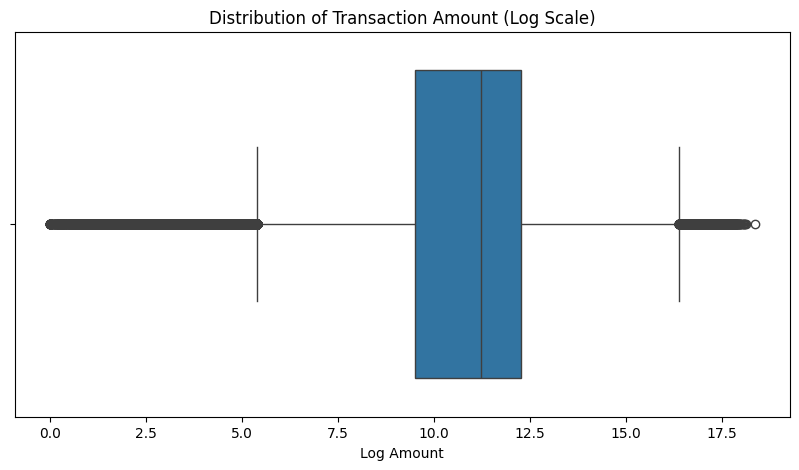

In [20]:
# Outlier Detection
plt.figure(figsize=(10, 5))
sns.boxplot(x=np.log1p(df['amount']))
plt.title("Distribution of Transaction Amount (Log Scale)")
plt.xlabel("Log Amount")
plt.show()

Since fraudulent transactions often involve unusually high amounts, we’ll visualize the amount column using a log scale. Instead of removing outliers, we’ll retain them, as they may represent fraud signals. In fraud detection, outliers are often important, not errors.

In [4]:
# Drop Irrelevant or Non-informative Columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [5]:
# Encode the Categorical type column

# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

We one-hot encode the type column to convert it into machine-readable form. Dropping the first category helps avoid dummy variable trap (multicollinearity among dummies).

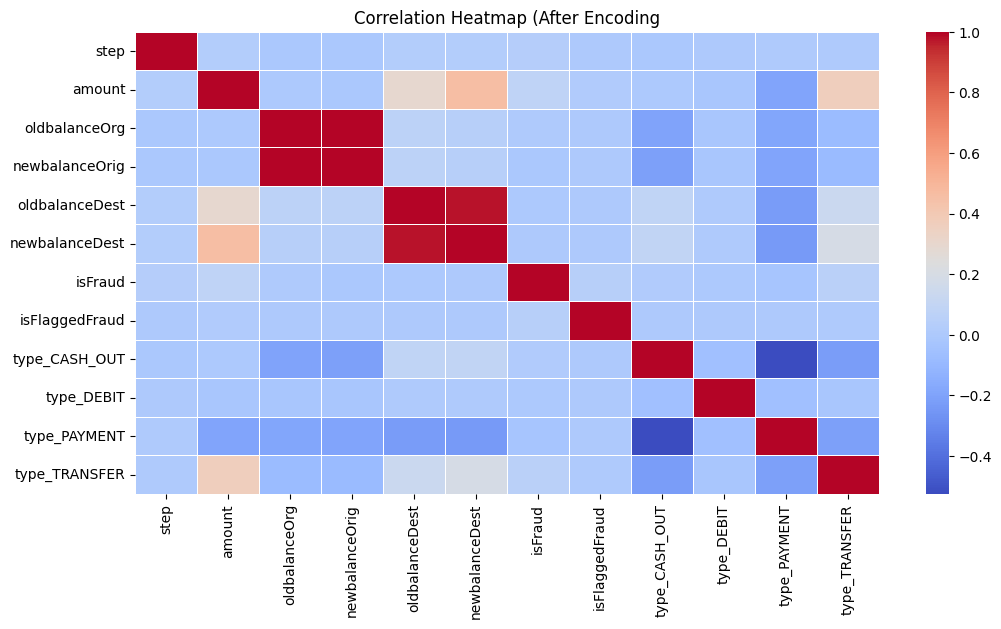

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=False,cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap (After Encoding")
plt.show()

After encoding, we re-evaluate multicollinearity. High correlation among features could confuse models like Logistic Regression. If strong multicollinearity is found, we may drop or combine some variables.

In [24]:
df.columns.tolist()

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER']

<h2>Feature Selection</h2>

In [6]:
df.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [7]:
# Correlation with target
corr_with_target=df.corr()['isFraud'].sort_values(ascending=False)
corr_with_target

isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
isFlaggedFraud    0.044109
step              0.031578
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_PAYMENT     -0.025697
Name: isFraud, dtype: float64

This gives us a quick idea of which features are positively or negatively correlated with fraud. Features with stronger correlation (even modest ones in classification tasks) can signal importance.

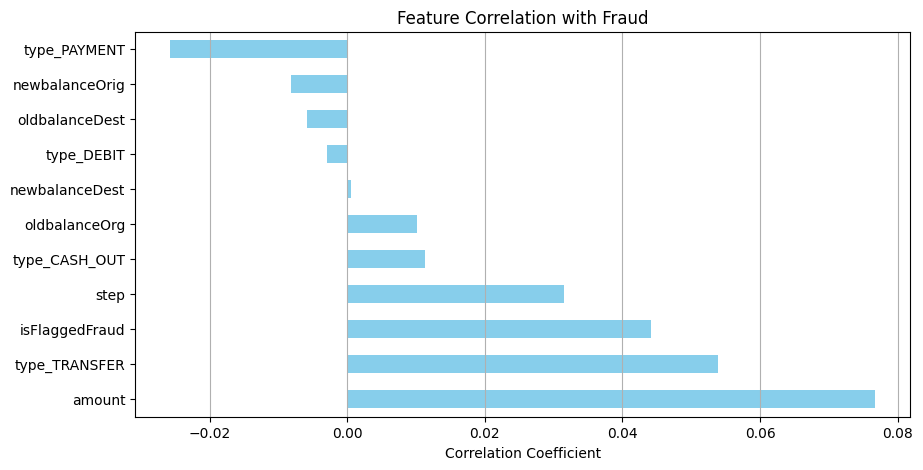

In [27]:
# Drop target itself and plot
corr_with_target.drop('isFraud').plot(kind='barh',figsize=(10,5),color='skyblue')
plt.title("Feature Correlation with Fraud")
plt.xlabel("Correlation Coefficient")
plt.grid(axis='x')
plt.show()

Even weak correlations can be helpful in classification models when used in combination. But this plot helps us narrow down which features seem to influence fraud most noticeably.

In [28]:
df['isFlaggedFraud'].value_counts(normalize=True)

isFlaggedFraud
0    0.999997
1    0.000003
Name: proportion, dtype: float64

Since most of the cells in df['isFlaggedFraud'] is 0 let's drop it

In [29]:
df.drop('isFlaggedFraud', axis=1, inplace=True)

In [30]:
features = df.drop('isFraud', axis=1).columns.tolist()
print("Final features to be used:", features)

Final features to be used: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


We’ll now use these features for model training. We avoided dropping useful numeric values like step, amount, and balances — as they carry transactional context that might help differentiate fraud.

<h2>Model Building and Evaluation</h2>

In [13]:
from sklearn.model_selection import train_test_split
X=df.drop('isFraud',axis=1)
y=df['isFraud']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

We split the dataset into training and test sets (80:20 ratio) using stratified sampling to preserve the proportion of fraud cases. This is important due to the highly imbalanced nature of the target variable.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score

lr_model=LogisticRegression(max_iter=1000,class_weight='balanced')
lr_model.fit(X_train,y_train)

y_pred=lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

KeyboardInterrupt: 

In [ ]:
# Model Evaluation
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [35]:
# Sample ~8% of data, stratified by fraud class
df_sampled = df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.08, random_state=42))

# Prepare features and labels
X = df_sampled.drop('isFraud', axis=1)
y = df_sampled['isFraud']

In [16]:
# Split Train/Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Estimate scale_pos_weight = (non-fraud / fraud)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.79      0.86      0.82       131

    accuracy                           1.00    101802
   macro avg       0.90      0.93      0.91    101802
weighted avg       1.00      1.00      1.00    101802



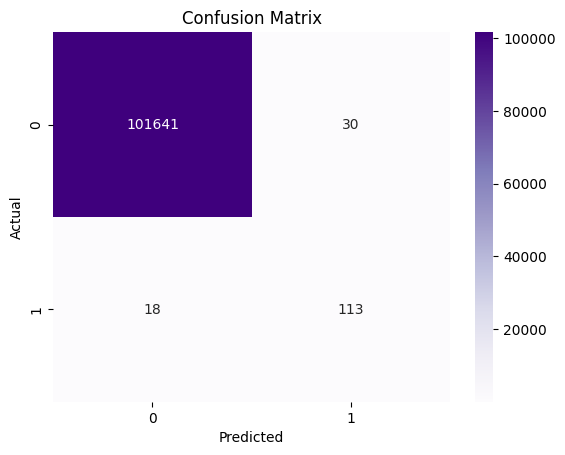

ROC-AUC Score: 0.9993577548177586


In [40]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


In [20]:
# Saving the trained model
xgb_model.save_model("xgb_fraud_model.json")

# To load it later
# from xgboost import XGBClassifier

# model = XGBClassifier()
# model.load_model("xgb_fraud_model.json")

<h2>Feature Importance and Interpretation</h2>

<Figure size 1000x600 with 0 Axes>

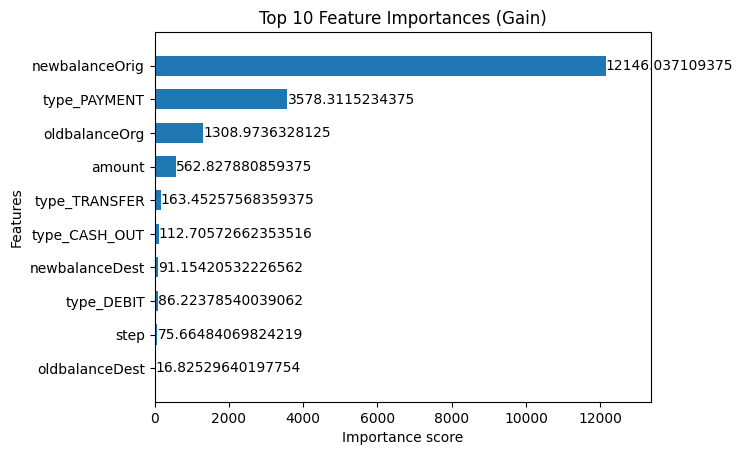

In [44]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10, height=0.6, grid=False)
plt.title("Top 10 Feature Importances (Gain)")
plt.show()

This plot shows the features that contributed the most to the model’s decisions. The importance is measured using the “gain”, which reflects the improvement in accuracy brought by a feature when it is used in a split.

<h3>Top features of of the dataset which were helpful in the fraud detection</h3>
The top predictors of fraud in this dataset align well with business intuition:

Transaction Amount: High-value transactions are more likely to be fraudulent, especially when combined with other suspicious patterns.

Old Balance of Origin: Fraudsters often target accounts with a significant balance to withdraw large amounts.

New Balance of Origin: A new balance of 0 after a large withdrawal is a red flag, suggesting full balance transfers.

Transfer Type: Most frauds happen in TRANSFER and CASH_OUT operations — this aligns with known fraud tactics like moving funds between mule accounts.

Old Balance of Destination: Sudden large incoming transactions to previously empty or low-balance accounts may indicate fraud rings.

<h3>Do These Features Make Sense?</h3>
Yes, the important features identified by the model are meaningful in the context of fraud detection:

Patterns involving balance changes are often signals of account takeovers or scams.

Fraudsters may initiate a TRANSFER or CASH_OUT from compromised accounts, often leaving the origin account empty.

The transaction amount, when unusually high, is a classic indicator of fraud, especially if paired with sudden account depletion.

These patterns are consistent with real-world fraud tactics, validating that the model is learning sensible relationships.



<h2>Recommendations + How to Measure Success</h2>

<h3>What kind of prevention should be adopted?</h3>
Based on the fraud patterns discovered in the dataset and model insights, the company can take the following preventive actions:

Real-Time Transaction Monitoring System:
Flag suspicious transactions — especially high-value TRANSFER and CASH_OUT types — when origin balances drop to near-zero.

Threshold-Based Alerts:
Create dynamic thresholds for users based on historical behavior. If a transaction exceeds 2× the user's typical volume, trigger a manual review or OTP verification.

Velocity Checks:
Track the number and value of transactions from a single account in a short time window (e.g., 5 mins). Unusually rapid activity is a red flag.

Blacklisting Destination Accounts:
Maintain a watchlist of destination accounts receiving multiple suspicious transfers (linked to mule accounts or laundering).

Machine Learning-Based Scoring System:
Deploy the XGBoost model in production to generate a risk score for every transaction in real-time. Transactions above a certain threshold can be auto-flagged or held for review.



<h3>How Would You Determine If These Actions Work?
</h3>
To measure the success of implemented fraud prevention actions, we would:

✅ Track Drop in Confirmed Fraud Cases

Compare the number of confirmed fraud cases before and after implementation.

✅ Monitor False Positives

Track the number of legitimate transactions that were incorrectly flagged to ensure customer experience isn't affected.

✅ Evaluate with Key Metrics Over Time

Periodically compute fraud detection metrics such as Recall, Precision, F1-score, and ROC-AUC to see if the model still performs well in production.

✅ A/B Test the System

Run the model on a subset of live traffic and compare fraud rates and alert performance against the existing system.

✅ Retrain Model Regularly

Set up pipelines to retrain the model as fraud patterns evolve and new data becomes available.

